# 1. Data Collection

In [463]:
from share import db_conn as db

In [13]:
### <mongo users demo>
# df_mongo_pandas = csv_make_df('mongo_demo_feat_discov_4.csv').toPandas()
# headers = df_mongo_pandas.iloc[0]
# df_mongo_pandas = pd.DataFrame(df_mongo_pandas.values[1:], columns=headers)
# df_mongo_pandas.drop(df_mongo_pandas.index[0])

### Imports From Amazon Redshift

In [464]:
import simplejson
import json
import pandas as pd
from datetime import datetime, time, timedelta
from pytz import timezone
from pyspark import SparkConf, SparkContext 
from pyspark.sql import SQLContext, SparkSession
from sqlalchemy import create_engine

with open("/home/data/rami/notebook/acc/redshift.json") as fh:
    creds = simplejson.loads(fh.read())
    pw = creds['password']
    host = creds['host_name']
    user = creds['user_name']
    port = creds['port_num']
    
with open("/home/data/rami/notebook/acc/redshift-ue.json") as ue:
    creds = simplejson.loads(ue.read())
    ue_pw = creds['password']
    ue_host = creds['host_name']
    ue_user = creds['user_name']
    ue_port = creds['port_num']
    
with open("/home/data/rami/utils/postgres_con.json") as pg:
    creds = simplejson.loads(pg.read())
    pg_pw = creds['password']
    pg_host = creds['host']
    pg_user = creds['user']
    pg_port = creds['port']

yesterday = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")

def sparksession():
    spark = SparkSession.builder \
        .master("local[*]") \
        .appName("data") \
        .config("spark.driver.extraClassPath",\
             "/home/data/share/postgresql-9.4.1207.jre7.jar")\
        .config("spark.driver.memory", "32g")\
        .config("spark.driver.cores", "16")\
        .config("spark.executor.memory", "32g")\
        .config("spark.executor.pyspark.memory", "32g")\
        .config("spark.python.worker.memory", "32g")\
        .config("spark.driver.maxResultSize", "32g")\
        .config("spark.sql.execution.arrow.enabled", "true")\
        .config("spark.sql.autoBroadcastJoinThreshold", "10485760")\
        .enableHiveSupport()\
        .getOrCreate()
    return spark

def spark_sql() :
    sql = SQLContext(sparksession())
    print(sparksession().sparkContext.uiWebUrl)
    return sql

def pg_make_df(table):
    print(datetime.now())
    
#     with open(f'/home/data/rami/dags/sql/{file}', 'r') as fd:
#         query = fd.read()
                 
    spark = sparksession()
                 
    df = spark.read.format("jdbc")\
      .option("url", f"jdbc:postgresql://{pg_host}:{pg_port}/postgres")\
      .option("dbtable", f"{table}")\
      .option("user", f'{pg_user}')\
      .option("password", f"{pg_pw}")\
      .option("driver", "org.postgresql.Driver")\
      .load()
    
    table = f'{table}'.split('.')[1]
    
    sql = SQLContext(spark)
    sql.registerDataFrameAsTable(df, f'{table}')
        
    print(f'{table}')
    return df


def dw_make_df(table, query):
    print(datetime.now())
                
    spark = sparksession()
    
#     with open(f'/home/data/rami/dags/sql/{file}', 'r') as fd:
#         query = fd.read()

    df = spark.read.format("jdbc")\
      .option("url", f"jdbc:postgresql://{host}:{port}/dev")\
      .option("dbtable", f"({query})")\
      .option("user", f'{user}')\
      .option("password", f"{pw}")\
      .option("driver", "org.postgresql.Driver")\
      .load()
        
    sql = SQLContext(spark)
    sql.registerDataFrameAsTable(df, f'{table}')
                     
    print(f'{table}')
    return df


def ue_make_df(table, query):
    print(datetime.now())
    
#     with open(f'/home/data/rami/dags/sql/{file}', 'r') as fd:
#         query = fd.read()
               
    spark = sparksession()                 

    df = spark.read.format("jdbc")\
      .option("url", f"jdbc:postgresql://{ue_host}:{ue_port}/dev")\
      .option("dbtable", f"({query})")\
      .option("user", f'{ue_user}')\
      .option("password", f"{ue_pw}")\
      .option("driver", "org.postgresql.Driver")\
      .load()
        
    sql = SQLContext(spark)
    sql.registerDataFrameAsTable(df, f'{table}')
       
    print(f'{table}')
    return df


def write_db(data, tablename, mode='overwrite'):
    print(datetime.now())
    
    with open("/home/data/rami/utils/postgres_con.json", "r") as pst_json:
        pst_json = json.load(pst_json)
    
    dbname=pst_json['dbname']
    user=pst_json['user']
    host=pst_json['host']
    pw=pst_json['password']
    port=pst_json['port']    
        
    data.write.mode(mode).format('jdbc')\
        .options(url=f"jdbc:postgresql://{host}:{port}/{dbname}",
                driver="org.postgresql.Driver",
                dbtable=tablename,
                user=user,
                password=pw,
                batchsize=1000000)\
        .save()

    print(datetime.now())
    
    
def pg_engine() :
    with open("/home/data/rami/utils/postgres_con.json", "r") as pst_json:
        pst_json = json.load(pst_json)
    
    dbname=pst_json['dbname']
    user=pst_json['user']
    host=pst_json['host']
    pw=pst_json['password']
    port=pst_json['port']
    
    engine = create_engine(f'postgresql+psycopg2://{user}:{pw}@{host}:{port}/{dbname}')
    return engine


def rs_engine() :
    with open("/home/data/rami/notebook/acc/redshift.json") as fh:
        creds = simplejson.loads(fh.read())
        pw = creds['password']
        host = creds['host_name']
        user = creds['user_name']
        port = creds['port_num']
    
    engine = create_engine(f'postgresql+psycopg2://{user}:{pw}@{host}:{port}/dev')
    return engine


def ue_engine() :
    with open("/home/data/rami/notebook/acc/redshift-ue.json") as ue:
        creds = simplejson.loads(ue.read())
        ue_pw = creds['password']
        ue_host = creds['host_name']
        ue_user = creds['user_name']
        ue_port = creds['port_num']
        
    user=ue_user
    host=ue_host
    pw=ue_pw
    port=ue_port
    
    engine = create_engine(f'postgresql+psycopg2://{user}:{pw}@{host}:{port}/dev')
    return engine


sql = db.spark_sql().sql

def csv_make_df(table):
    
    spark = sparksession()
    
    df = spark.read.csv(table)
    sql = SQLContext(spark)
    sql.registerDataFrameAsTable(df, 'df_mongo')
    
    print(f'{table}')
    return df

http://ip-172-31-30-177.ap-northeast-2.compute.internal:4040


In [465]:


df_aw = db.dw_make_df('df_aw',
f"""



select
    distinct a.*,
    b.brand,
    b.boundness,
    b.internal_category,
    b.package_name,
    b.amount,
    b.discount_amount,
    b.klass_state,
    case 
        when b.klass_state = 'basuga' then dateadd(hour, 9, b.occurred_at) 
        when b.klass_state = 'earlybird' then dateadd(hour, 9, b.basuga_at) 
    else null end as orders_avail_at_kst,
    datediff(minute, first_avail_kst, orders_avail_at_kst) as order_ticket_diff,
    
    case when b.product_f_id in ('rxi3tBXaDn15KIbcKpvp',
                                       'KuXds4cRdqsP28J8EzRT',
                                       'yQEyTuTyjdkyFDwCRvBJ', 
                                       'nkzfA7AG5vqjXKyFNYpo',
                                       '636tOlPFOrBSTiu6nw2A', 
                                       '5iunVXbZZLUGrmSDuoX5',
                                       '0op5oCZQa92BeOi8VzC8',
                                       'dSo0jklY4frWRz76LnSS',
                                       'NqCPZ2EIg43Ny6NXInyV',
                                       'Sc4zTMMLchQP3ps1sazo',
                                       'xMv9mRK6Ql2u1iYOsPje',
                                       'LfuSl2SdlshuOfNffbLg',
                                       'mHUaGm8pxxUZBkuzn2OU',
                                       'uBaXSzeifCl9MRphoW99',
                                       'I0FyAZSf7HswbewOiDsW') then 'chuseok'
               WHEN b.product_f_id IN ('0MPzSsUIvA2FzkhBzr8k',
									'dTZOgJBN00KZrOrbXfZq',
									'DMqhqLv0AHfby3UW21aS',
									'tq0f5N51oXsFgwVU43Ar') THEN 'tutorial101'
			   WHEN b.product_f_id IN ('price101Klass08',
									'price101Klass07',
									'price101Klass05',
									'price101Klass10',
									'price101Klass03',
									'GAm4C1Z3vmSYYxdxGAiW',
									'price101Klass06',
									'price101Klass09',
									'price101Klass02',
									'3BMKeWkodNUCuTMrXZ3S',
									'JuMhGo5fcRxbj1tZKmbn',
									'price101Klass04',
									'price101Klass11',
									'Vfj5LNsKwUYiwYyYT9q6') THEN 'price101'
               WHEN b.product_f_id = 'VqrEyNm59NfvYYEDQi41' THEN 'hang_gong_gwon'
               WHEN b.product_f_id = 'WLbJk0PRMk7KhCl7yd7j' THEN 'straw_queen'
               WHEN b.product_f_id IN ('uHMGNVjOppKCNUdnHiZB',
									'koreagrandma',
									'GWRNbjpJ8hPA2M685Qmz') THEN 'donation'
               WHEN b.product_f_id IN ('ur1deuIyLaMGeFQFus47',
									'FFgIsJnIfWGsHXhG0JYG',
									'muyB2zj4BjG60gXRgH1E',
									'rQWABXv9j6AMEvD9VlYO',
									'7n7JeIDVakjMgZNDqlpN',
									'TCYSx4mHGyvyKFEQT08u',
									'nSJSAPWSqmWHQ8MObGsH',
									'lz1ZhQdctsXZVhVXPGr6') THEN 'tasting101'
               WHEN b.product_title LIKE '%101원 맛보기%' THEN 'tasting101'
               WHEN b.product_f_id IN ('payment',
									'sales2',
									'presale',
									'rpXgQW7eiucGP4UG6ZKH',
									'sales4',
									'han-lab',
									'Igbfp7QoxhP9vgyUSZvM',
									'X012boW2VLNdw3jArG5d',
									'Wu0FQRnJVk0JMZ3s2UAt',
									'GF81UJvBjnD9VXks8mZ6',
									'donut-lab') THEN 'test'
                else 'other'
                end is_event,

    case when b.product_f_id in (select distinct product_f_id
                from (
                
                    select 
                        product_f_id,
                        min(occurred_at) period
                    from (
                        select 
                            product_f_id,
                            occurred_at + interval '9 hours' occurred_at,
                            sum(amount) over(partition by product_f_id order by occurred_at rows unbounded preceding) cumorderamount
                        from 
                            premart_production.orders oo
                        where 
                            klass_state = 'earlybird')
                    where 
                        cumorderamount >= 50000000
                    group by 1
                    
                    union all
                    
                    select 
                        product_f_id,
                        min(occurred_at) period
                    from (
                        select 
                            product_f_id,
                            occurred_at + interval '9 hours' occurred_at,
                            sum(ordercnt) over(partition by product_f_id order by occurred_at rows unbounded preceding) cumordercnt
                        from (
                            select 
                                product_f_id, 
                                occurred_at, 
                                count(distinct order_m_id) ordercnt
                            from 
                                premart_production.orders oo
                            where 
                                klass_state = 'earlybird'
                                and amount > 0
                                and valid
                            group by 1,2)
                            )
                    where 
                        cumordercnt >= 250
                    group by 1)
                    ) then 1 else 0 end as is_hero,
                    
    case when b.product_f_id in ('09GSRFWW1luDeCYF8BnH',
										'2xnP6X19UoflTu10YOI8',
										'6cYSU9lJOcx619NQbuhb',
										'7HgOnALNS50weWf4lHo9',
										'82ztVQjVVHqj6foQ7VXN',
										'AyRAr423hpZQqC12xli6',
										'bzNBYc7FzLkAW9fx3jSi',
										'cRfhyRrJQPbRq1er28pX',
										'CXiK0oTkrl59Rj6ZEhjJ',
										'dEBtmcVZqa02bK65UVyS',
										'GlakGRgxWd33dG9Eoit5',
										'HNi96776HQRRBT4ckXEW',
										'IIwcU5v9INIIdXWOhT5U',
										'iQZsFmHs8EftrC5MryTu',
										'Jg9cKbxbmUupktaGDVig',
										'LcYvAMeE5fXVomwXCP8D',
										'PHsGy7fQNVA3br9YHo2m',
										'Q7u18FOR1NaYcisgDF1b',
										'rZh71KBPE5puitG1JPHY',
										'U2rXKi3U5B2xY00QmmIA',
										'V7d8qdYoITA8RAdABSW0',
										'xLl6SclDTl0NNOlzTyPs',
										'yGuwkHJtrwkyx2X6KiQO',
										'galaxynote10',
										'rGeYJRGZ1HW1Of2K8jEK',
										'V7d8qdYoITA8RAdABSW0',
										'xsP7RjH7L89dBAIu8lNl',
                                        'V4Vjr810vWPY4JrEiDxE') then 1 else 0 end as is_branded
                
from (
    select
        a.*, -- 53 rows here,
        sum(case when dateadd(hour, 9, b.occurred_at) < DATEADD(hour, 24*182, first_avail_kst)
            then amount else 0 end) as sum_revenue_182days
    from (
        select
            distinct a.*, -- 52 rows here,
            b.order_m_id
        from (
        
            select
                a.*,
                sum(case when created_at < first_avail_kst then 1 else 0 end) wish_before,
                sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_10days_kst
                    then 1 else 0 end) wish_10days,
                sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_30days_kst
                    then 1 else 0 end) wish_30days,
                sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_90days_kst
                    then 1 else 0 end) wish_90days,
                sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_150days_kst
                    then 1 else 0 end) wish_150days
                    
            from (
                select
                    a.*,
                    sum(case when cheer_at < first_avail_kst then 1 else 0 end) cheers_before,
                    sum(case when dateadd(hour, 9, b.cheer_at) >= first_avail_kst and dateadd(hour, 9, b.cheer_at) < first_avail_10days_kst
                        then 1 else 0 end) cheers_10days,
                    sum(case when dateadd(hour, 9, b.cheer_at) >= first_avail_kst and dateadd(hour, 9, b.cheer_at) < first_avail_30days_kst
                        then 1 else 0 end) cheers_30days,
                    sum(case when dateadd(hour, 9, b.cheer_at) >= first_avail_kst and dateadd(hour, 9, b.cheer_at) < first_avail_90days_kst
                        then 1 else 0 end) cheers_90days,
                    sum(case when dateadd(hour, 9, b.cheer_at) >= first_avail_kst and dateadd(hour, 9, b.cheer_at) < first_avail_150days_kst
                        then 1 else 0 end) cheers_150days
                from (
                    select
                        a.*,
                        sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_1day_kst
                            then 1 else 0 end) comments_1day,
                        sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_3days_kst
                            then 1 else 0 end) comments_3days,
                        sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_10days_kst
                            then 1 else 0 end) comments_10days,
                        sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_30days_kst
                            then 1 else 0 end) comments_30days,
                        sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_90days_kst
                            then 1 else 0 end) comments_90days,
                        sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_150days_kst
                            then 1 else 0 end) comments_150days
                    from (
                        select
                            a.*,
                            
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_1day_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures where lecture_completed_condition = 'VIEWED_CONTENT')
                                then 1 else 0 end) nonmission_posts_1day,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_3days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures where lecture_completed_condition = 'VIEWED_CONTENT')
                                then 1 else 0 end) nonmission_posts_3days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_10days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures where lecture_completed_condition = 'VIEWED_CONTENT')
                                then 1 else 0 end) nonmission_posts_10days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_30days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures where lecture_completed_condition = 'VIEWED_CONTENT')
                                then 1 else 0 end) nonmission_posts_30days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_90days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures where lecture_completed_condition = 'VIEWED_CONTENT')
                                then 1 else 0 end) nonmission_posts_90days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_150days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures where lecture_completed_condition = 'VIEWED_CONTENT')
                                then 1 else 0 end) nonmission_posts_150days,
                            
                            
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_1day_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures)
                                then 1 else 0 end) posts_1day,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_3days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures)
                                then 1 else 0 end) posts_3days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_10days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures)
                                then 1 else 0 end) posts_10days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_30days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures)
                                then 1 else 0 end) posts_30days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_90days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures)
                                then 1 else 0 end) posts_90days,
                            sum(case when dateadd(hour, 9, b.created_at) >= first_avail_kst and dateadd(hour, 9, b.created_at) < first_avail_150days_kst
                                and lecture_m_id in (select lecture_m_id from premart_production.lectures)
                                then 1 else 0 end) posts_150days
                            
                        from (
                            select
                                a.*,
                                b.non_secret_chamber_total_lecture_count,
                                b.difficulty,
                                
                                sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_1day_kst
                                    then 1 else 0 end) completed_lectures_1day,
                                sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_3days_kst
                                    then 1 else 0 end) completed_lectures_3days,
                                sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_10days_kst
                                    then 1 else 0 end) completed_lectures_10days,
                                sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_30days_kst
                                    then 1 else 0 end) completed_lectures_30days,
                                sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_90days_kst
                                    then 1 else 0 end) completed_lectures_90days,
                                sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_150days_kst
                                    then 1 else 0 end) completed_lectures_150days,
                                
                                cast(sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_1day_kst
                                    then 1 else 0 end) as float) / b.non_secret_chamber_total_lecture_count as completed_lectures_ratio_1day,
                                    
                                cast(sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_3days_kst
                                    then 1 else 0 end) as float)  / b.non_secret_chamber_total_lecture_count as completed_lectures_ratio_3days,
                                    
                                cast(sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_10days_kst
                                    then 1 else 0 end) as float)  / b.non_secret_chamber_total_lecture_count as completed_lectures_ratio_10days,
                                    
                                cast(sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_30days_kst
                                    then 1 else 0 end) as float)  / b.non_secret_chamber_total_lecture_count as completed_lectures_ratio_30days,
                                    
                                cast(sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_90days_kst
                                    then 1 else 0 end) as float)  / b.non_secret_chamber_total_lecture_count as completed_lectures_ratio_90days,
                                    
                                cast(sum(case when dateadd(hour, 9, b.completed_at) >= first_avail_kst and dateadd(hour, 9, b.completed_at) < first_avail_150days_kst
                                    then 1 else 0 end) as float)  / b.non_secret_chamber_total_lecture_count as completed_lectures_ratio_150days
                                
                            from (
                                select
                                    distinct a.*,
                                    b.account_type
                                from
                                    (select
                                        a.user_f_id,
                                        a.klass_m_id,
                                        a.ticket_start_at_kst as first_avail_kst,
                                        DATEADD(hour, 24, first_avail_kst) as first_avail_1day_kst,
                                        DATEADD(hour, 24*3, first_avail_kst) as first_avail_3days_kst,
                                        DATEADD(hour, 24*10, first_avail_kst) as first_avail_10days_kst,
                                        DATEADD(hour, 24*30, first_avail_kst) as first_avail_30days_kst,
                                        DATEADD(hour, 24*90, first_avail_kst) as first_avail_90days_kst,
                                        DATEADD(hour, 24*150, first_avail_kst) as first_avail_150days_kst
                                    from (
                                        select
                                            a.user_f_id,
                                            b.ticket_start_at_kst,
                                            a.klass_m_id
                                        from
                                            raw_production.klass_tickets a
                                        left join
                                            (select 
                                                user_f_id, 
                                                min(DATEADD(hour, 9, start_at)) as ticket_start_at_kst
                                            from 
                                                raw_production.klass_tickets
                                            where
                                                start_at IS NOT NULL
                                                AND is_payment_completed IS TRUE
                                                AND ticket_valid_day>=50
                                            group by 1) b
                                            on a.user_f_id = b.user_f_id
                                            and DATEADD(hour, 9, a.start_at) = b.ticket_start_at_kst
                                            ) a
                                    where
                                        a.ticket_start_at_kst >= '2020-09-01'
                                        and a.ticket_start_at_kst < '2020-12-01') a
                                left join
                                    premart_production.users b
                                    on a.user_f_id = b.user_f_id
                                where 
                                    is_admin is false) a
                                    
                            left join
                                (select
                                	a.user_f_id, 
                                	a.klass_m_id,
                                	a.ticket_m_id,
                                	b.non_secret_chamber_total_lecture_count,
                                	b.difficulty,
                                	c.lecture_m_id,
                                	c.completed_at
                                from
                                	(select
                                		*
                                	from
                                		premart_production.tickets
                                	where
                                		is_payment_completed is TRUE
                                		and deleted_at is null) as a
                                left outer join 
                                    (select
                                		*
                                	from
                                		mart_production.klasses ) as b 
                                	on a.klass_m_id = b.klass_m_id
                                left outer join
                                	(select
                                		ticket_m_id, 
                                		klass_m_id, 
                                		lecture_m_id,
                                		completed_at
                                	from
                                		mart_production.completed_lectures cl
                                	where 
                                	    is_secret_chamber is not true) as c 
                                	on a.ticket_m_id = c.ticket_m_id
                                	and a.klass_m_id = c.klass_m_id) b
                                on a.user_f_id = b.user_f_id
                                and a.klass_m_id = b.klass_m_id
                            where
                                b.non_secret_chamber_total_lecture_count > 0
                            group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12) a
            
                        left join
                            raw_production.posts b
                            on a.user_f_id = b.user_f_id
                        group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24) a
                    left join
                        premart_production.comments b
                        on a.user_f_id = b.user_f_id
                    group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36) a
                left join
                    premart_production.cheer_up b
                    on a.user_f_id = b.cheer_user_f_id
                group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42) a
            left join
                raw_production.reservations b
                on a.user_f_id = b.user_f_id
            group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47) a
        left join
            (select 
                distinct user_f_id,
                klass_m_id,
                order_m_id
            from 
                raw_production.klass_item_orders 
            where 
                order_state = 'PAID') b
            on a.user_f_id = b.user_f_id
            and a.klass_m_id = b.klass_m_id) a 
    left join
        premart_production.orders b
        on a.user_f_id = b.user_f_id
    where
        amount > 10000
        and confirm_state = 'approved'
    group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53) a
left join
    premart_production.orders b
    on a.user_f_id = b.user_f_id
where 
    amount > 10000
    and confirm_state = 'approved'
    
""")

2021-06-02 06:29:18.117698
df_aw


In [15]:
df_aw_spark = sql(
"""
select 
    a.*,
    b.min_order_ticket_diff,
    case when a.completed_lectures_ratio_150days = 1 then 1 else 0 end as completed_class
from
    df_aw a
left join
    (select 
        user_f_id, 
        min(order_ticket_diff) as min_order_ticket_diff 
    from 
        df_aw
    group by 1) b
    on a.user_f_id = b.user_f_id
where
    a.order_ticket_diff = b.min_order_ticket_diff

""")

### Imports From User Events DB

In [16]:

df_ue = db.ue_make_df('df_ue',
f"""
select
    distinct user_id as user_f_id, 
    class_id,
    device,
    lv_kst as access_kst,
    'lv' as access_type
    
from (
    select user_id, class_id, date_add('hour',9,timestamp) as lv_kst, 'android' as device
    from class101_app_android_production.lecture_viewed
    where lecture_is_free is false
    union
    select user_id, class_id, date_add('hour',9,timestamp) as lv_kst, 'ios'
    from class101_app_ios_production.lecture_viewed
    where lecture_is_free is false
    union
    select user_id, class_id, date_add('hour',9,timestamp) as lv_kst, 'web'
    from class101_web_production.lecture_viewed
    where lecture_is_free is false
    union
    select user_id, class_id, date_add('hour',9,timestamp) as lv_kst, 'ios'
    from class101_app_ios_production.viewed_content
    union
    select user_id, class_id, date_add('hour',9,timestamp) as lv_kst, 'android'
    from class101_app_android_production.viewed_content)
where
    lv_kst >= '2020-01-01'

union



select
    distinct user_id as user_f_id, 
    class_id,
    device,
    pv_kst as access_kst,
    'pv'
from (
    select user_id, class_id, date_add('hour',9,timestamp) as pv_kst, 'android' as device
    from class101_app_android_production.lecture_proceeded
    where lecture_is_free is false
    union
    select user_id, class_id, date_add('hour',9,timestamp) as pv_kst, 'ios'
    from class101_app_ios_production.lecture_proceeded
    where lecture_is_free is false
    union
    select user_id, class_id, date_add('hour',9,timestamp) as pv_kst, 'web'
    from class101_web_production.lecture_proceeded
    where lecture_is_free is false)
where
    pv_kst >= '2020-01-01'
""")

2021-06-01 07:06:25.385003
df_ue


In [17]:
#df_aw_pandas = df_aw_spark.toPandas()
#df_aw_pandas.columns.to_series().apply(lambda x: x.replace(',', '/')).reset_index(drop=True)
#df_aw_pandas['sum_revenue_182days'].sort_values()

### Merging Datasets

In [18]:
df_aw_ue_spark = sql(
"""
select
    a.user_f_id,
    klass_m_id,
    first_avail_kst,
    first_avail_1day_kst,
    first_avail_3days_kst,
    first_avail_10days_kst,
    first_avail_30days_kst,
    first_avail_90days_kst,
    first_avail_150days_kst,
    account_type,
    completed_lectures_1day,
    completed_lectures_3days,
    completed_lectures_10days,
    completed_lectures_30days,
    completed_lectures_90days,
    completed_lectures_150days,
    completed_lectures_ratio_1day,
    completed_lectures_ratio_3days,
    completed_lectures_ratio_10days,
    completed_lectures_ratio_30days,
    completed_lectures_ratio_90days,
    completed_lectures_ratio_150days,
    nonmission_posts_1day,
    nonmission_posts_3days,
    nonmission_posts_10days,
    nonmission_posts_30days,
    nonmission_posts_90days,
    nonmission_posts_150days,
    posts_1day,
    posts_3days,
    posts_10days,
    posts_30days,
    posts_90days,
    posts_150days,
    comments_1day,
    comments_3days,
    comments_10days,
    comments_30days,
    comments_90days,
    comments_150days,
    cheers_before,
    cheers_10days,
    cheers_30days,
    cheers_90days,
    cheers_150days,
    wish_before,
    wish_10days,
    wish_30days,
    wish_90days,
    wish_150days,
    completed_class,
    order_m_id,
    sum_revenue_182days,
    brand,
    boundness,
    internal_category,
    package_name,
    discount_amount,
    is_event,
    is_hero,
    is_branded,
    difficulty,
    amount,
    klass_state,
    orders_avail_at_kst,
    order_ticket_diff,
    min_order_ticket_diff,
    
    count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_1day_kst
        then b.user_f_id else null end) as lv_count_1day,
    count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_3days_kst
        then b.user_f_id else null end) as lv_count_3days,
    count(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_10days_kst
        then b.user_f_id else null end) as lv_count_10days,
    count(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_30days_kst
        then b.user_f_id else null end) as lv_count_30days,
    count(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_90days_kst
        then b.user_f_id else null end) as lv_count_90days,
    count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
        then b.user_f_id else null end) as lv_count_150days,



    case when count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
        then b.user_f_id else null end)=0 then 0
        else 
            cast(count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                and device = 'web'
                then b.user_f_id else null end) as float) /
            count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                then b.user_f_id else null end) 
        end as lv_web_ratio_150days,
                
    case when count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
        then b.user_f_id else null end)=0 then 0
        else 
            cast(count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                and device = 'ios'
                then b.user_f_id else null end) as float) /
            count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                then b.user_f_id else null end) end as lv_ios_ratio_150days,
    case when count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
            then b.user_f_id else null end)=0 then 0
            else 
                cast(count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                    and device = 'android'
                    then b.user_f_id else null end) as float) /
                count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                    then b.user_f_id else null end) end as lv_android_ratio_150days,
    case when count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
            then b.user_f_id else null end)=0 then 0
            else 
                cast(count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                    and device in ('ios', 'android')
                    then b.user_f_id else null end) as float) /
                count(case when b.access_kst >= a.first_avail_kst and b.access_kst < a.first_avail_150days_kst
                    then b.user_f_id else null end) end as lv_app_ratio_150days,



    count(distinct(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_150days_kst
        then extract(hour from b.access_kst) else null end)) as lv_distinct_hours_150days,
    
    count(distinct(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_3days_kst
        then date(b.access_kst) else null end)) as count_distinctdays_3days,
    count(distinct(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_10days_kst
        then date(b.access_kst) else null end)) as count_distinctdays_10days,
    count(distinct(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_30days_kst
        then date(b.access_kst) else null end)) as count_distinctdays_30days,
    count(distinct(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_90days_kst
        then date(b.access_kst) else null end)) as count_distinctdays_90days,
    count(distinct(case when
            b.access_kst >= a.first_avail_kst
            and b.access_kst < a.first_avail_150days_kst
        then date(b.access_kst) else null end)) as count_distinctdays_150days


from (
    select 
        a.*,
        b.min_order_ticket_diff,
        case when a.completed_lectures_ratio_150days = 1 then 1 else 0 end as completed_class
    from
        df_aw a
    left join
        (select 
            user_f_id, 
            min(order_ticket_diff) as min_order_ticket_diff 
        from 
            df_aw
        group by 1) b
        on a.user_f_id = b.user_f_id
    where
        a.order_ticket_diff = b.min_order_ticket_diff) a
        
left join
    df_ue b
    on a.user_f_id = b.user_f_id
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67
        
""")

In [19]:
#turn merged data into pandas
df_aw_ue_pandas = df_aw_ue_spark.toPandas()

In [ ]:
#mongo merges
#df_all_merged = pd.merge(df_aw_ue_pandas_final, df_mongo_pandas, how = 'inner', left_on='user_f_id', right_on='user_f_id')

# 2. Data Polishing

In [466]:
df_aw_ue_pandas_final = df_aw_ue_pandas[(df_aw_ue_pandas['order_ticket_diff']<1440*10)&(df_aw_ue_pandas['order_ticket_diff']> -1440*10)]

In [467]:
df_aw_ue_pandas_final.loc[df_aw_ue_pandas_final['sum_revenue_182days'] == df_aw_ue_pandas_final['amount'], 'rebuy_182days'] = 0
df_aw_ue_pandas_final.loc[df_aw_ue_pandas_final['sum_revenue_182days'] != df_aw_ue_pandas_final['amount'], 'rebuy_182days'] = 1

/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a co

In [468]:
df_final_drop = ['klass_m_id','account_type','order_m_id',
                 'first_avail_kst',
                'first_avail_1day_kst', 'first_avail_3days_kst', 
                 'first_avail_10days_kst', 'first_avail_30days_kst',
                 'first_avail_90days_kst', 'first_avail_150days_kst',
                 'orders_avail_at_kst', 'min_order_ticket_diff',
                  'completed_lectures_1day',
                    'completed_lectures_3days',
                    'completed_lectures_10days',
                    'completed_lectures_30days',
                    'completed_lectures_90days',
                    'completed_lectures_150days']
df_final = df_aw_ue_pandas_final.drop(df_final_drop, axis=1)


In [469]:
df_final['discount_ratio'] = df_final['discount_amount']/(df_final['amount']+df_final['discount_amount'])
df_final = df_final.drop(columns='discount_amount')

In [471]:
df_final['internal_category'][df_final.internal_category.str.contains('career|dataAndDevelopment|careerVideoAndDesign|writeContent', na=False)] = 'career'
df_final['internal_category'][df_final.internal_category.str.contains('signature|oa|workout|cooking|lifestyle|photograph|music|sns', na=False)] = 'other'
df_final['internal_category'][df_final.internal_category.str.contains('stock|onlineShop|founded', na=False)] = 'money'

df_final['brand'][df_final.brand.str.contains('gym|signature', na=False)] = 'other'

df_final['package_name'][df_final.package_name.str.contains('only|Only|ONLY', na=False)] = 'only'
df_final['package_name'][df_final.package_name.str.contains('올인원', na=False)] = 'allin'
df_final['package_name'][df_final.package_name.str.contains('베이직', na=False)] = 'basic'
df_final['package_name'][df_final.package_name.str.contains('코칭', na=False)] = 'coaching'
df_final['package_name'][~df_final.package_name.str.contains('only|allin|coaching', na=False)] = 'others'





/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [149]:
#df_amount[df_aw_ue_pandas_final['discount_rati'] == 0]

In [150]:
#df_final.groupby('age')['user_f_id'].count().sort_values()

In [151]:
# df_final['address'][df_final.address.str.contains('서울', na=False)] = 'seoul'
# df_final['address'][df_final.address.str.contains('경기', na=False)] = 'gyunggi'
# df_final['address'][df_final.address.str.contains('인천', na=False)] = 'incheon'
# df_final['address'][df_final.address.str.contains('부산', na=False)] = 'busan'
# df_final['address'][df_final.address.str.contains('경기', na=False)] = 'gyunggi'
# df_final['address'][df_final.address.str.contains('전남', na=False)] = 'cheonnam'
# df_final['address'][df_final.address.str.contains('전북', na=False)] = 'cheonbook'
# df_final['address'][df_final.address.str.contains('대전', na=False)] = 'daejon'
# df_final['address'][df_final.address.str.contains('대구', na=False)] = 'daegu'
# df_final['address'][df_final.address.str.contains('제주', na=False)] = 'jaeju'
# df_final['address'][df_final.address.str.contains('광주', na=False)] = 'gwangju'
# df_final['address'][df_final.address.str.contains('울산', na=False)] = 'ulsan'
# df_final['address'][df_final.address.str.contains('경북', na=False)] = 'gyungbook'
# df_final['address'][df_final.address.str.contains('충남', na=False)] = 'choongnam'
# df_final['address'][df_final.address.str.contains('충북', na=False)] = 'choongbook'
# df_final['address'][df_final.address.str.contains('강원', na=False)] = 'gwangwon'
# df_final['address'][df_final.address.str.contains('경남', na=False)] = 'gyungnam'
# df_final['address'][df_final.address.str.contains('세종', na=False)] = 'sejong'
# df_final['address'][~df_final.address.str.contains('seoul|gyunggi|incheon|busan|gyunggi|cheonnam|cheonbook|daejon|daegu|jaeju|gwangju|ulsan|gyungbook|choongnam|choongbook|gwangwon|gyungnam|sejong', na=False)] = 'others'


# df_final['address'][df_final.address.str.contains('seoul|gyunggi|incheon', na=False)] = 'capital'
# df_final['address'][~df_final.address.str.contains('capital', na=False)] = 'others'

# #df_final['address'][~df_final.address.str.contains(
#  #   'insta|alarmtalk|naver|kakao|facebook|google|youtube|email|creator|push|lms', na=False)] = 'other'


In [152]:
#mongo demo stuff
#df_final.loc[df_final['gender'].isna(), 'gender'] = 'other'
#df_final.loc[df_final['age'].isna(), 'age'] = df_final['age'].astype('float').mean()

In [472]:
df_final = df_final.rename(columns={'first_row':'utm_count'})

In [473]:
df_final_user_f_id_drop = ['user_f_id']
df_final = df_final.drop(df_final_user_f_id_drop, axis=1)


In [474]:
df_final['order_ticket_diff'] = abs(df_final['order_ticket_diff'])

In [475]:
#df_final['age'] = df_final['age'].astype('float')
df_final['comments_1day'] = df_final['comments_1day'].astype('float')
df_final['comments_1day'] = df_final['comments_1day'].astype('float')
df_final['comments_1day'] = df_final['comments_1day'].astype('float')
df_final['comments_1day'] = df_final['comments_1day'].astype('float')

In [157]:
#get rid of columns with null values
#df_final = df_final[~df_final.isnull().any(axis=1)]

In [158]:
#df_final[df_final.isnull().any(axis=1)]

In [476]:
#for classification
df_final = df_final.drop("sum_revenue_182days", axis=1)

In [160]:
#df_aw_ue_pandas_final[corr_top_15].columns

In [161]:
#df_final['nonmission_posts_90days'].sort_values(ascending=False).head(30)

In [162]:
#outliers
'''
feature = 'cheers_150days'
value = 19
df_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]

feature = 'completed_lectures_150days'
value = 240
df_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]

feature = 'cheers_150days'
value = 19
df_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]

feature = 'completed_lectures_150days'
value = 240
df_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]




feature = 'completed_lectures_30days'
value = 140
df_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]

feature = 'nonmission_posts_150days'
value = 100
df_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]





feature = 'posts_90days'
value = 60
df_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]





feature = 'posts_150days'
value = 100
df_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]

feature = 'cheers_150days'
value = 19
df_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]

feature = 'completed_lectures_150days'
value = 240
df_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]'''

"\nfeature = 'cheers_150days'\nvalue = 19\ndf_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]\n\nfeature = 'completed_lectures_150days'\nvalue = 240\ndf_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]\n\nfeature = 'cheers_150days'\nvalue = 19\ndf_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]\n\nfeature = 'completed_lectures_150days'\nvalue = 240\ndf_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]\n\n\n\n\nfeature = 'completed_lectures_30days'\nvalue = 140\ndf_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]\n\nfeature = 'nonmission_posts_150days'\nvalue = 100\ndf_aw_ue_pandas_final[feature] = df_aw_ue_pandas_final[df_aw_ue_pandas_final[feature] < value][feature]\n\n\n\n\n\nfeature = 'posts_90days'\nvalue = 60\ndf_aw_ue_panda

# 3. Background Analysis


In [477]:
import math
from math import sqrt
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from statsmodels.api import OLS

# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

# algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor, plot_importance

In [478]:
df_final

,completed_lectures_ratio_1day,completed_lectures_ratio_3days,completed_lectures_ratio_10days,completed_lectures_ratio_30days,completed_lectures_ratio_90days,completed_lectures_ratio_150days,nonmission_posts_1day,nonmission_posts_3days,nonmission_posts_10days,nonmission_posts_30days,...,lv_android_ratio_150days,lv_app_ratio_150days,lv_distinct_hours_150days,count_distinctdays_3days,count_distinctdays_10days,count_distinctdays_30days,count_distinctdays_90days,count_distinctdays_150days,rebuy_182days,discount_ratio
0,0.000000,0.000000,0.058824,0.058824,0.058824,0.264706,0,0,0,0,...,0.573770,0.573770,12,2,4,4,24,27,0.0,0.174634
1,0.424242,0.454545,0.484848,0.606061,0.606061,0.606061,0,0,0,0,...,0.000000,0.292683,16,2,7,13,15,16,0.0,0.464354
2,0.000000,0.000000,0.000000,0.553191,0.744681,0.744681,0,0,0,1,...,0.982759,0.982759,18,0,0,15,38,38,0.0,0.253156
3,0.195122,0.292683,0.292683,0.463415,0.512195,0.512195,0,0,0,1,...,0.000000,0.118852,19,4,4,11,22,24,1.0,0.451456
4,0.140625,0.187500,0.203125,0.218750,0.218750,0.375000,0,0,0,0,...,0.000000,1.000000,21,3,8,21,45,71,1.0,0.276326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,...,0.000000,0.000000,0,0,0,0,0,0,0.0,0.355033
53992,0.000000,0.028571,0.028571,0.028571,0.028571,0.028571,0,0,0,0,...,0.000000,0.000000,0,0,0,0,0,0,0.0,0.340468
53993,0.000000,0.018519,0.074074,0.074074,0.129630,0.314815,0,0,0,0,...,0.000000,0.000000,0,0,0,0,0,0,0.0,0.321958
53994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,...,0.000000,1.000000,1,0,0,0,0,1,0.0,0.335570


In [596]:
#one-hot-encoding (to turn non-numerical input data into numerical)
object_columns = df_final.select_dtypes(include=['object']).columns

df_final_dummies = pd.get_dummies(df_final[object_columns.to_list()])
res = pd.concat([df_final, df_final_dummies], axis=1)
df_final_dummies = res.drop(object_columns.to_list(), axis=1)


### 3a) Simple Averages Comparison

In [598]:
zeros_dict = {}
ones_dict = {}

for i in df_final_dummies.columns[:-1]:
    zeros_mean = round(df_final_dummies[df_final_dummies['rebuy_182days'] == 0][i].mean(), 3)
    zeros_dict[i]=zeros_mean

for i in df_final_dummies.columns[:-1]:
    ones_mean = round(df_final_dummies[df_final_dummies['rebuy_182days'] == 1][i].mean(), 3)
    ones_dict[i]=ones_mean

zeros = pd.DataFrame.from_dict(zeros_dict, orient='index', columns=['no_rebuy_182days_avg'])
ones = pd.DataFrame.from_dict(ones_dict, orient='index', columns=['yes_rebuy_182days_avg'])

avg_summary = pd.concat([zeros,ones],axis=1)
avg_summary = pd.concat([zeros,ones,avg_summary['yes_rebuy_182days_avg']-avg_summary['no_rebuy_182days_avg'], round((avg_summary['yes_rebuy_182days_avg']/avg_summary['no_rebuy_182days_avg'])*100, 2)],axis=1)
avg_summary = avg_summary.rename(columns={0:'diff',1:'perc_diff'})
pd.options.display.max_rows = 20
avg_summary.sort_values('perc_diff', ascending=False)

avg_summary.sort_values('perc_diff', ascending=False).head(20)


,no_rebuy_182days_avg,yes_rebuy_182days_avg,diff,perc_diff
rebuy_182days,0.000,1.000,1.000,inf
comments_10days,0.008,0.049,0.041,612.50
order_ticket_diff,54.294,237.089,182.795,436.68
cheers_150days,0.282,1.116,0.834,395.74
wish_150days,1.416,5.585,4.169,394.42
wish_90days,1.128,4.171,3.043,369.77
cheers_90days,0.242,0.880,0.638,363.64
comments_30days,0.029,0.103,0.074,355.17
comments_3days,0.003,0.010,0.007,333.33
comments_90days,0.091,0.294,0.203,323.08


### 3b) Correlation Matrix and Pairplots

In [599]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51052 entries, 0 to 53995
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   completed_lectures_ratio_1day     51052 non-null  float64
 1   completed_lectures_ratio_3days    51052 non-null  float64
 2   completed_lectures_ratio_10days   51052 non-null  float64
 3   completed_lectures_ratio_30days   51052 non-null  float64
 4   completed_lectures_ratio_90days   51052 non-null  float64
 5   completed_lectures_ratio_150days  51052 non-null  float64
 6   nonmission_posts_1day             51052 non-null  int64  
 7   nonmission_posts_3days            51052 non-null  int64  
 8   nonmission_posts_10days           51052 non-null  int64  
 9   nonmission_posts_30days           51052 non-null  int64  
 10  nonmission_posts_90days           51052 non-null  int64  
 11  nonmission_posts_150days          51052 non-null  int64  
 12  post

In [600]:
df_final_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51052 entries, 0 to 53995
Data columns (total 84 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   completed_lectures_ratio_1day             51052 non-null  float64
 1   completed_lectures_ratio_3days            51052 non-null  float64
 2   completed_lectures_ratio_10days           51052 non-null  float64
 3   completed_lectures_ratio_30days           51052 non-null  float64
 4   completed_lectures_ratio_90days           51052 non-null  float64
 5   completed_lectures_ratio_150days          51052 non-null  float64
 6   nonmission_posts_1day                     51052 non-null  int64  
 7   nonmission_posts_3days                    51052 non-null  int64  
 8   nonmission_posts_10days                   51052 non-null  int64  
 9   nonmission_posts_30days                   51052 non-null  int64  
 10  nonmission_posts_90days           

In [601]:
### top 20 correlation (with Y) features

corr = df_final_dummies.corr(method='spearman')
corr_top_20 = corr['rebuy_182days'].sort_values(ascending=False)[0:21].reset_index()['index'].tolist()
abs(round(corr['rebuy_182days'].sort_values(ascending=False)[1:21]*100, 2)).head(50)
#abs(corr['rebuy_182days'].sort_values(ascending=False))[1:30]




wish_150days                  32.54
wish_90days                   28.76
lv_count_150days              25.57
count_distinctdays_150days    25.00
lv_distinct_hours_150days     24.22
cheers_150days                23.24
posts_150days                 23.19
wish_30days                   21.84
cheers_90days                 20.74
count_distinctdays_90days     20.58
lv_count_90days               20.47
posts_90days                  18.81
wish_10days                   15.80
nonmission_posts_150days      15.55
cheers_30days                 15.41
count_distinctdays_30days     13.23
nonmission_posts_90days       12.73
wish_before                   12.48
lv_count_30days               12.43
order_ticket_diff             12.40
Name: rebuy_182days, dtype: float64

In [484]:
# correlation : spearman 
# spearman's measures the strength and direction of association between two ranked variables.
#corr = df_final_dummies.corr(method='spearman')

# heatmap
#plt.figure(figsize=(30, 30))
#sns.heatmap(corr, annot=True, cmap="YlGnBu")
#plt.show()

In [99]:
### data too big

#import seaborn as sns
#sns.set_theme(style="ticks")

#sns.pairplot(df_final_dummies[corr_top_15])

# 4. Running Models

In [602]:
#split data
X = df_final_dummies.drop("rebuy_182days", axis=1)
Y = df_final_dummies["rebuy_182days"].astype('int64')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

### 4a) Start by Fitting All Classification Models

In [603]:
### all models with the basic df_final_dummies

# random forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_train = random_forest.predict(X_test)
Y_pred_test = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_test, Y_test) * 100, 2)

# stochastic gradient descent (SGD) learning
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_test, Y_test) * 100, 2)

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_test, Y_test) * 100, 2)

# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_test, Y_test) * 100, 2)

# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_test, Y_test) * 100, 2)

# Perceptron
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_test, Y_test) * 100, 2)

# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_test, Y_test) * 100, 2)

# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_test, Y_test) * 100, 2)

#XGBoost
# xg_reg = XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 10)
# xg_reg.fit(X_train,Y_train)
# Y_pred = xg_reg.predict(X_test)
# acc_xg_reg = round(xg_reg.score(X_test, Y_test) * 100, 2)


results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'
              #, 'XGBoost'
             ],
    'Test Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree
                   #, acc_xg_reg
                  ]})
result_df = results.sort_values(by='Test Score', ascending=False)
result_df = result_df.set_index('Test Score').reset_index()
result_df.head(8)

/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Test Score,Model
0,80.91,Random Forest
1,76.31,Logistic Regression
2,75.04,Naive Bayes
3,73.79,Perceptron
4,73.13,Stochastic Gradient Decent
5,72.41,Decision Tree
6,71.69,KNN
7,27.90,Support Vector Machines


### 4b) Zoom-in on Random Forest - trial 1

##### <Train Score & Cross-validated Test Scores>

In [604]:

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

rf_Y_pred_train = random_forest.predict(X_train)
rf_Y_pred_test = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print("Train Score", round(acc_random_forest,2,), "%")

rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=3, scoring = "accuracy")

print("Test Scores Mean:", round(scores.mean()*100, 2))
print("Test Scores:", scores)
print("Test Scores Standard Deviation:", scores.std())

Train Score 99.95 %
Test Scores Mean: 80.27
Test Scores: [0.80571471 0.79961804 0.80283552]
Test Scores Standard Deviation: 0.002490230123352371


##### <Precision, Recall, F1-scores>

In [605]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print(confusion_matrix(Y_test,rf_Y_pred_test))
print(classification_report(Y_test,rf_Y_pred_test))
#print(accuracy_score(Y_test,rf_Y_pred_test))
print('F1 Score', f1_score(Y_test,rf_Y_pred_test))

[[7129  335]
 [1627 1120]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      7464
           1       0.77      0.41      0.53      2747

    accuracy                           0.81     10211
   macro avg       0.79      0.68      0.71     10211
weighted avg       0.80      0.81      0.79     10211

F1 Score 0.5330794859590671


##### <RMSE & Accuracy Score>

In [606]:
import math
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error


rmse_train = round(sqrt(mean_squared_error(Y_train, rf_Y_pred_train)), 2)
rmse_test = round(sqrt(mean_squared_error(Y_test, rf_Y_pred_test)), 2)
r2_train = round(r2_score(Y_train, rf_Y_pred_train)*100, 2)
r2_test = round(r2_score(Y_test, rf_Y_pred_test)*100, 2)
acc_train = round(accuracy_score(Y_train, rf_Y_pred_train)*100, 2)
acc_test = round(accuracy_score(Y_test, rf_Y_pred_test)*100, 2)

print(rmse_train, rmse_test, acc_train, acc_test)

#rmse is absolute measure
#r_2 is relative measure


0.02 0.44 99.95 80.79


### 4c) Zoom in on Random Forest - Some More Tunings

##### <Hyperparameter Tuning,>

In [607]:

#from sklearn.model_selection import GridSearchCV

#forest = RandomForestClassifier(random_state = 1)
#modelF = forest.fit(X_train_2, Y_train_2)
#y_predF = modelF.predict(X_test_2)

In [608]:
# n_estimators = [100, 200]
# max_depth = [2, 8, 15, 25]
# min_samples_split = [2, 5, 10, 15]
# min_samples_leaf = [1, 2, 5] 

# hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
#                       n_jobs = -1)
# bestF = gridF.fit(X_test_2, Y_test_2)

##### <Feature Selection Through Permutation Feature Importance,>

In [609]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 52488 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/ubuntu/miniconda3/envs/py37/

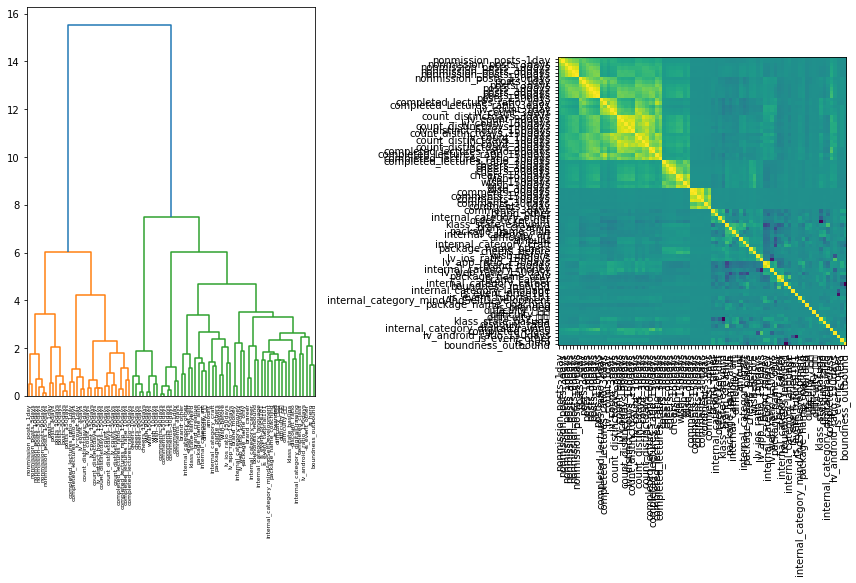

In [610]:
##### Taking out correlated features by looking at their hierarchical relationship on a dendrogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
#X = X.drop(columns='is_event_other')
corr_perm = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr_perm)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=X.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr_perm[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [611]:
#Removed correlated features and ran RF again, no luck though :'(
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train.iloc[:,selected_features]
X_test_sel = X_test.iloc[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, Y_train)
print("Accuracy on test data with features before removed: {:.2f}".format(
      random_forest.score(X_test, Y_test)))
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, Y_test)))

Accuracy on test data with features before removed: 0.81
Accuracy on test data with features removed: 0.78


In [612]:
#these are the 'selected features' by the correlation removement algorithm
X_train.iloc[:,selected_features].columns

Index(['completed_lectures_ratio_1day', 'completed_lectures_ratio_10days',
       'completed_lectures_ratio_90days', 'nonmission_posts_1day',
       'nonmission_posts_10days', 'posts_1day', 'posts_10days',
       'comments_1day', 'comments_10days', 'cheers_before', 'cheers_10days',
       'wish_10days', 'completed_class', 'is_hero', 'is_branded', 'amount',
       'order_ticket_diff', 'lv_count_1day', 'lv_count_10days',
       'lv_count_90days', 'lv_web_ratio_150days', 'lv_ios_ratio_150days',
       'lv_android_ratio_150days', 'lv_app_ratio_150days', 'discount_ratio',
       'brand_career', 'brand_creative', 'brand_money', 'brand_other',
       'boundness_inbound', 'boundness_outbound', 'internal_category_art',
       'internal_category_craft', 'internal_category_digitalDrawing',
       'internal_category_language',
       'internal_category_mindAndSelfDevelopment', 'package_name_allin',
       'package_name_coaching', 'package_name_only', 'package_name_others',
       'is_event_other',

##### <Permutation Feature Importance With Correlation Removed,>

/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0, flags=flags)
/home

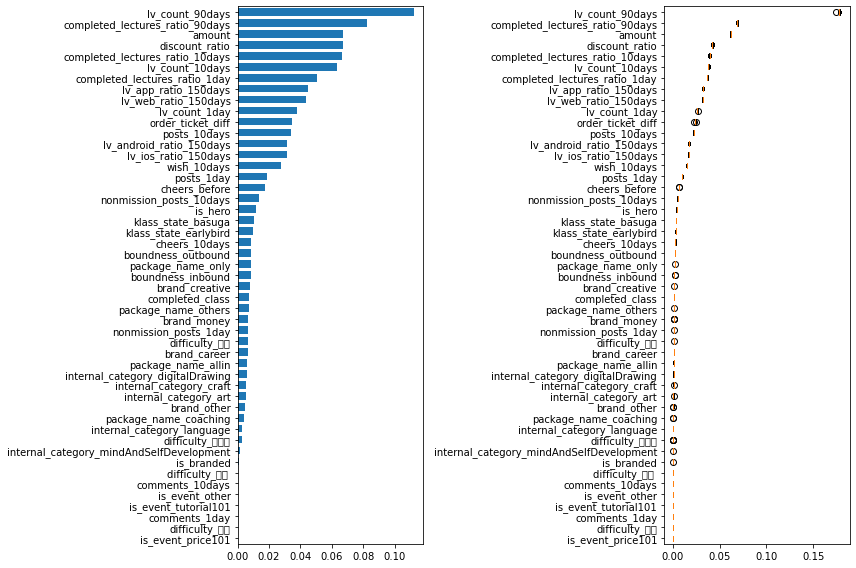

In [613]:
result = permutation_importance(clf_sel, X_train_sel, Y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf_sel.feature_importances_)
tree_indices = np.arange(0, len(clf_sel.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf_sel.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(np.array(X_train_sel.columns.tolist())[tree_importance_sorted_idx.astype(int)])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf_sel.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=np.array(X_train_sel.columns.tolist())[tree_importance_sorted_idx.astype(int)])
fig.tight_layout()
plt.show()

### 4d) Zoom in on LogReg and Do T-test on "Selected" Features

In [614]:
#get logreg coef p-values of correlation removed features

#copy paste above above query result for now
trial_2_features = ['completed_lectures_ratio_1day', 'completed_lectures_ratio_10days',
       'completed_lectures_ratio_90days', 'nonmission_posts_1day',
       'nonmission_posts_10days', 'posts_1day', 'posts_10days',
       'comments_1day', 'comments_10days', 'cheers_before', 'cheers_10days',
       'wish_10days', 'completed_class', 'is_hero', 'is_branded', 'amount',
       'order_ticket_diff', 'lv_count_1day', 'lv_count_10days',
       'lv_count_90days', 'lv_web_ratio_150days', 'lv_ios_ratio_150days',
       'lv_android_ratio_150days', 'lv_app_ratio_150days', 'discount_ratio',
       'brand_career', 'brand_creative', 'brand_money', 'brand_other',
       'boundness_inbound', 'boundness_outbound', 'internal_category_art',
       'internal_category_craft', 'internal_category_digitalDrawing',
       'internal_category_language',
       'internal_category_mindAndSelfDevelopment', 'package_name_allin',
       'package_name_coaching', 'package_name_only', 'package_name_others',
       'is_event_other', 'is_event_price101', 'is_event_tutorial101',
       'difficulty_중급', 'difficulty_초급', 'difficulty_초급 ', 'difficulty_초중급',
       'klass_state_basuga', 'klass_state_earlybird']
#df_final_dummies.iloc[:,selected_features].columns


In [615]:

X_train_2 = X_train[trial_2_features]
Y_train_2 = Y_train
X_test_2 = X_test[trial_2_features]
Y_test_2 = Y_test

logreg_2 = LogisticRegression()
logreg_2.fit(X_train_2, Y_train_2)

Y_pred_train_2 = logreg_2.predict(X_train_2)
Y_pred_test_2 = logreg_2.predict(X_test_2)


acc_log = round(logreg_2.score(X_train_2, Y_train_2) * 100, 2)


ols_summary_2 = pd.DataFrame(OLS(Y,X).fit().summary().tables[1])
new_header_2 = ols_summary_2.iloc[0] #grab the first row for the header
ols_summary_2 = ols_summary_2[1:] #take the data less the header row
ols_summary_2.columns = new_header_2 #set the header row as the df header

ols_summary_2.columns.values[0] = 'feature'
ols_summary_2.columns.values[1] = 'coef'
ols_summary_2.columns.values[4] = 'p'
ols_summary_2['p'] = ols_summary_2['p'].astype('string').astype('float')
ols_summary_2['feature'] = ols_summary_2['feature'].astype('string')
ols_summary_2['coef'] = abs(ols_summary_2['coef'].astype('string').astype('float'))


ols_results = ols_summary_2[ols_summary_2['p']<0.05].sort_values('coef', ascending=False).reset_index(drop=True)
#ols_summary_2[ols_summary_2.sort_values('coef', ascending=False).reset_index(drop=True)['feature'] == 'completed_lectures_90days']
#ols_summary_2[ols_summary_2['feature'] == '']
#ols_summary_2[ols_summary_2['feature'] == 'completed_lectures_10days']
list(ols_results['feature'])
#ols_results

['completed_lectures_ratio_150days',
 'difficulty_초급 ',
 'discount_ratio',
 'completed_lectures_ratio_30days',
 'completed_lectures_ratio_3days',
 'completed_lectures_ratio_90days',
 'internal_category_language',
 'completed_class',
 'package_name_coaching',
 'internal_category_money',
 'lv_web_ratio_150days',
 'internal_category_other',
 'klass_state_earlybird',
 'difficulty_초급',
 'boundness_inbound',
 'boundness_outbound',
 'internal_category_career',
 'difficulty_초중급',
 'internal_category_digitalDrawing',
 'package_name_only',
 'is_hero',
 'brand_creative',
 'internal_category_craft',
 'lv_distinct_hours_150days',
 'cheers_30days',
 'cheers_before',
 'lv_app_ratio_150days',
 'nonmission_posts_3days',
 'cheers_150days',
 'nonmission_posts_150days',
 'posts_3days',
 'posts_150days',
 'count_distinctdays_30days',
 'count_distinctdays_10days',
 'wish_150days',
 'wish_90days',
 'wish_30days',
 'count_distinctdays_90days',
 'lv_count_150days',
 'lv_count_90days',
 'lv_count_10days',
 'ord

In [616]:

### random forest trial 3 stuff

# X_2 = df_final_dummies[trial_2_features].drop("rebuy_182days", axis=1)
# Y_2 = df_final_dummies["rebuy_182days"].astype('int64')
# X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_2, Y_2, test_size=0.20, random_state=42)

# random_forest_2 = RandomForestClassifier(n_estimators=100, max_depth=22)
# random_forest_2.fit(X_train_2, Y_train_2)

# rf_Y_pred_train_2 = random_forest_2.predict(X_train_2)
# rf_Y_pred_test_2 = random_forest_2.predict(X_test_2)

# random_forest_2.score(X_train_2, Y_train_2)
# acc_random_forest_train_2 = round(random_forest_2.score(X_train_2, Y_train_2) * 100, 2)
# acc_random_forest_test_2 = round(random_forest_2.score(X_test_2, Y_test_2) * 100, 2)
# print(round(acc_random_forest_train_2,2,), "%")
# print(round(acc_random_forest_test_2,2,), "%")


# #do this on trial 2 rf
# result = permutation_importance(random_forest_2, X_train_2, Y_train_2, n_repeats=10,
#                                 random_state=42)
# perm_sorted_idx = result.importances_mean.argsort()

# tree_importance_sorted_idx = np.argsort(random_forest_2.feature_importances_)
# tree_indices = np.arange(0, len(random_forest_2.feature_importances_)) + 0.5

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# ax1.barh(tree_indices,
#          random_forest_2.feature_importances_[tree_importance_sorted_idx], height=0.7)
# ax1.set_yticklabels(np.array(X.columns.tolist())[tree_importance_sorted_idx.astype(int)])
# ax1.set_yticks(tree_indices)
# ax1.set_ylim((0, len(random_forest_2.feature_importances_)))
# ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
#             labels=np.array(X.columns.tolist())[tree_importance_sorted_idx.astype(int)])
# fig.tight_layout()
# plt.show()

In [647]:
df_final_dummies[df_final_dummies['completed_class'] == 1].count()

completed_lectures_ratio_1day      3800
completed_lectures_ratio_3days     3800
completed_lectures_ratio_10days    3800
completed_lectures_ratio_30days    3800
completed_lectures_ratio_90days    3800
                                   ... 
difficulty_초급                      3800
difficulty_초급                      3800
difficulty_초중급                     3800
klass_state_basuga                 3800
klass_state_earlybird              3800
Length: 84, dtype: int64

## 5) Results Dive-in

In [617]:
#function to make avg X vs Y table
def avg_table(feature, dff, y_value_number):
    a = dff.groupby([dff[feature]])[y_value_number].sum().sort_values(ascending=False).astype(int)
    b = dff.groupby([dff[feature]])[y_value_number].count().sort_values(ascending=False)
    c = a.to_frame().round(0).merge(b.to_frame(), left_on = feature, right_on = feature, how = 'inner').reset_index()
    c['avg'] = c['{}_x'.format(y_value_number)].div(c['{}_y'.format(y_value_number)]).round(2)
    d = c.rename(columns={"{}_y".format(y_value_number): "count_users", "{}_x".format(y_value_number): y_value_number})
    return d

In [708]:
#function to make scatter plot out of the "avg X vs Y table"
def make_graph(feature, dff_number, y_value_number, table):

    data_1 = avg_table(feature, dff_number, y_value_number).sort_values('avg',ascending=False).reset_index(drop=True)
    
    x = data_1[feature]
    y = data_1['avg']

    colors = data_1['avg']
    area = data_1['count_users']
    
    fig = plt.figure()
    ax_1 = fig.add_subplot(111)

    #for k, v in data_1[['count_users','avg']].iterrows():
    #    plt.annotate(k, v)
    ax_1.set_xlabel(str(feature))
    ax_1.set_xlim(xlim_min, xlim_max)
    ax_1.set_ylim(ylim_min, ylim_max)
    ax_1.set_ylabel(y_value_number)
    ax_1.set_title('scatter plot of ' + str(feature))
    ax_1.scatter(x, y, s=area, c=colors, alpha=0.5)
    #ax_1.figure(figsize=(20, 20))
    
    if y_value_number == 'rebuy_182days':
        color_list = ['#F5B14C', 'blue']
        color = color_list[1]
        m, b = np.polyfit(x, y, 1)
        ax_1.plot(x, m*x + b, color=color)
        ax_1.text(xlim_max*0.5, ylim_max*0.75, 'avg data (linear): ' + str(round(m, 4))+"x"+str(round(b, 4)), size = 10, alpha =.8, color='blue')

        x_true = df_final_dummies[feature]
        y_true = df_final_dummies[y_value_number]
        m_true, b_true = np.polyfit(x_true, y_true, 1)
        ax_1.plot(x_true, m_true*x_true + b_true, '-',color='black')
        ax_1.text(xlim_max*0.5, ylim_max*0.8, 'raw data (linear): ' + str(round(m_true, 4))+"x"+str(round(b_true, 4)), size = 10, alpha =.8, color='black')
        
        p = np.poly1d(np.polyfit(x, y, 3))
        t = np.linspace(0, xlim_max, xlim_max)
        ax_1.plot(t, p(t), '-', color='red')
        ax_1.text(xlim_max*0.5, ylim_max*0.7, 'avg data (poly3): ' + str(p), size = 10, alpha =.8, color='red')
        
    else:
        pass
    
    if table == 1:
        return avg_table(feature, dff_number, y_value_number).sort_values('avg',ascending=False).reset_index(drop=True)
    else: print()
        
    fig.set_size_inches(10, 10, forward=True)
    print(str(round(m, 4))+"x"+str(round(b, 4)))

def make_graph_amount(feature, dff_number, y_value_number, table):

    data_1 = avg_table(feature, dff_number, y_value_number).sort_values('avg',ascending=False).reset_index(drop=True)
    data_1 = data_1[data_1['count_users'] > 200]
    
    x = data_1[feature]
    y = data_1['avg']

    colors = data_1['avg']
    area = data_1['count_users']
    
    fig = plt.figure()
    ax_1 = fig.add_subplot(111)

    #for k, v in data_1[['count_users','avg']].iterrows():
    #    plt.annotate(k, v)
    ax_1.set_xlabel(str(feature))
    ax_1.set_xlim(xlim_min, xlim_max)
    ax_1.set_ylim(ylim_min, ylim_max)
    ax_1.set_ylabel(y_value_number)
    ax_1.set_title('scatter plot of ' + str(feature))
    ax_1.scatter(x, y, s=area, c=colors, alpha=0.5)
    #ax_1.figure(figsize=(20, 20))
    
    if y_value_number == 'rebuy_182days':
        color_list = ['#F5B14C', 'blue']
        color = color_list[1]
        m, b = np.polyfit(x, y, 1)
        ax_1.plot(x, m*x + b, color=color)
        #ax_1.text(xlim_max*0.5, ylim_max*0.75, 'avg data (linear): ' + str(round(m, 4))+"x"+str(round(b, 4)), size = 10, alpha =.8, color='blue')

        x_true = df_final_dummies[feature]
        y_true = df_final_dummies[y_value_number]
        m_true, b_true = np.polyfit(x_true, y_true, 1)
        ax_1.plot(x_true, m_true*x_true + b_true, '-',color='black')
        #ax_1.text(xlim_max*0.5, ylim_max*0.8, 'raw data (linear): ' + str(round(m_true, 4))+"x"+str(round(b_true, 4)), size = 10, alpha =.8, color='black')
        
        p = np.poly1d(np.polyfit(x, y, 3))
        t = np.linspace(0, xlim_max, xlim_max)
        ax_1.plot(t, p(t), '-', color='red')
        #ax_1.text(xlim_max*0.5, ylim_max*0.7, 'avg data (poly3): ' + str(p), size = 10, alpha =.8, color='red')
        
    else:
        pass
    
    if table == 1:
        return avg_table(feature, dff_number, y_value_number).sort_values('avg',ascending=False).reset_index(drop=True)
    else: print()
        
    fig.set_size_inches(10, 10, forward=True)
    print(str(round(m, 4))+"x"+str(round(b, 4)))
    print(data_1['count_users'].sum())

### A-1) Lecture View Count Within 90 days


0.0003x0.383


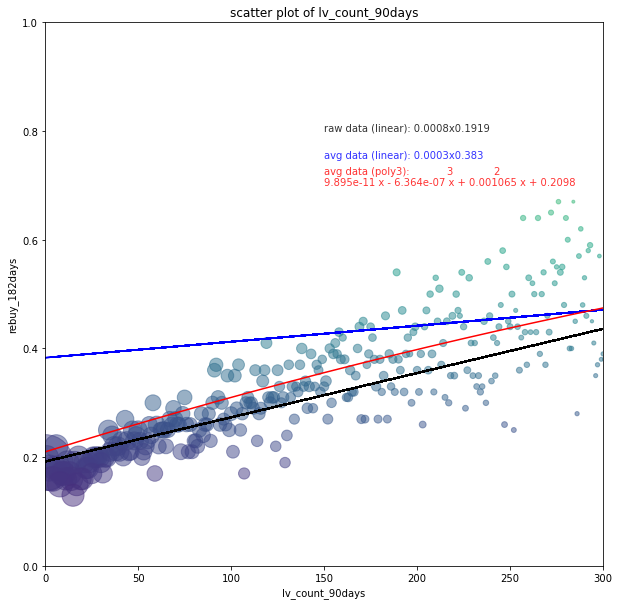

In [619]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'lv_count_90days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 300
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### A-2) Lecture View Count Within 24 hours


0.0016x0.2257


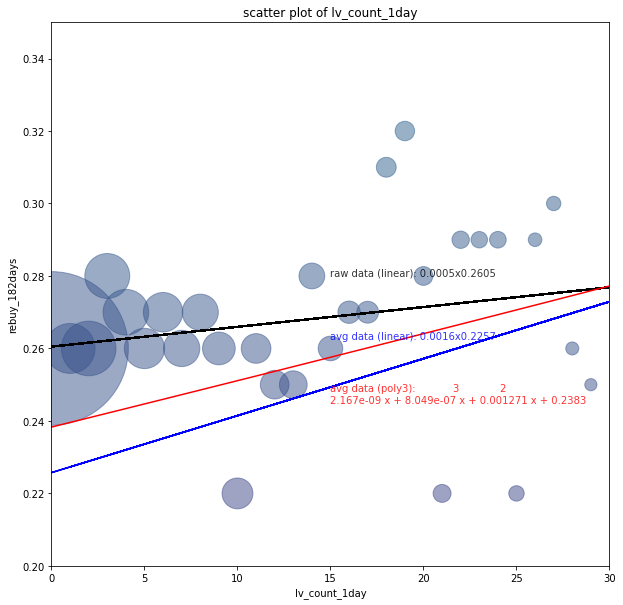

In [650]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'lv_count_1day'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 30
ylim_min = 0.2
ylim_max = 0.35

make_graph(feature, dff_number, y_value_number, table)


### A-3) Distinct Lecture View Days Within 150 Days


0.0026x0.2678


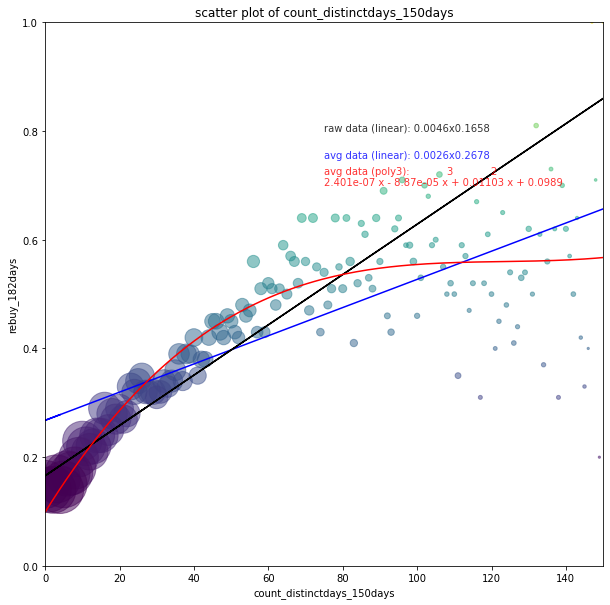

In [621]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'count_distinctdays_150days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 150
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### A-4) Distinct Lecture View Hours Within 150 Days


0.0185x0.0672


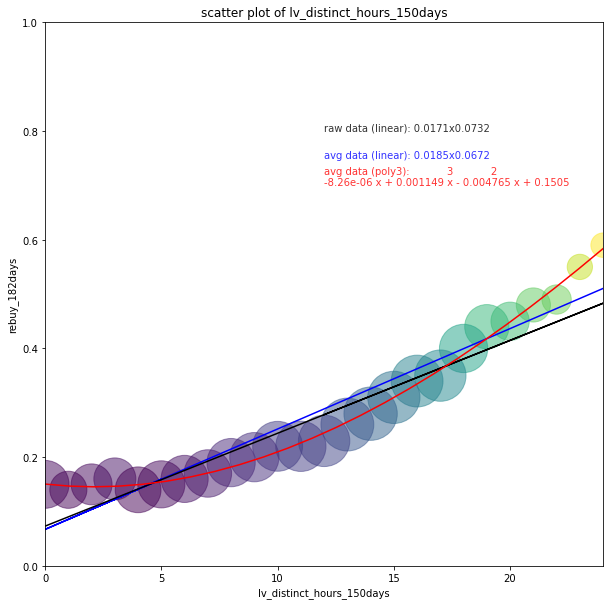

In [622]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'lv_distinct_hours_150days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 24
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### B) Completed Lecture Ratio Within 90 Days


0.1781x0.1877


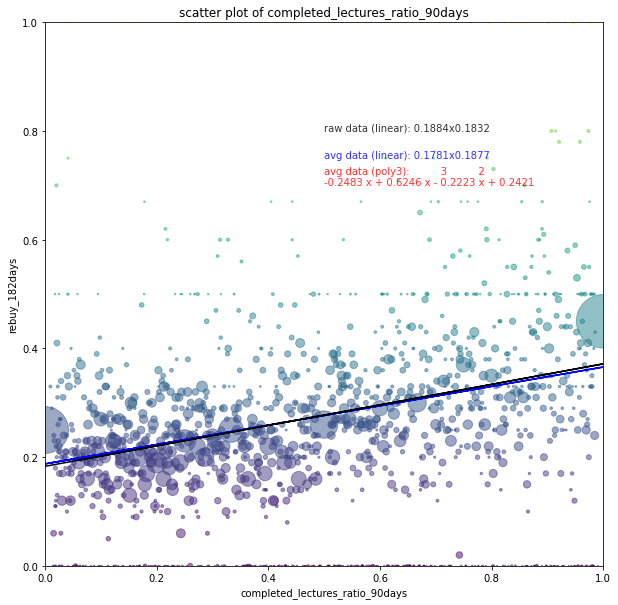

In [623]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'completed_lectures_ratio_90days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 1
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### C-1) Purchase Amount -- Zoomed Out



0.0x0.2949


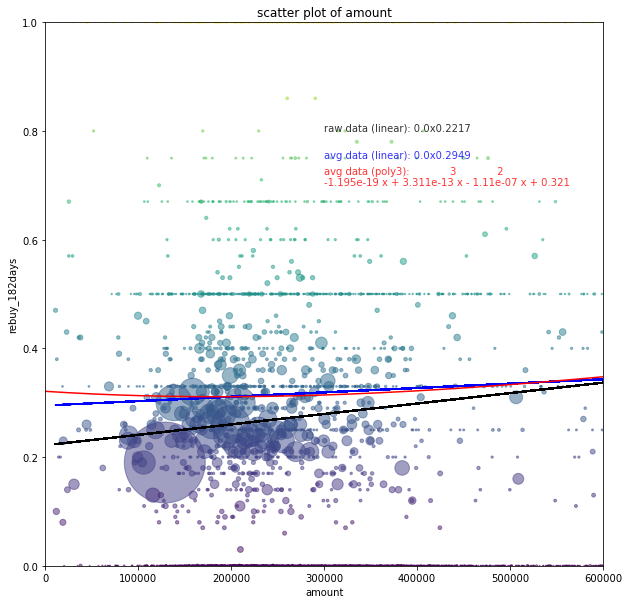

In [713]:
df_amount = df_final_dummies[df_final_dummies['amount'] != 0]

dff_list = [df_aw_ue_pandas_final, df_final_dummies, df_amount]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'amount'
dff_value = 2
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 600000
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)
#avg_table(feature, dff_number, y_value_number).sort_values('count_users',ascending=False).reset_index(drop=True)

### C-1) Purchase Amount -- Zoomed In


0.0x0.2479
23658


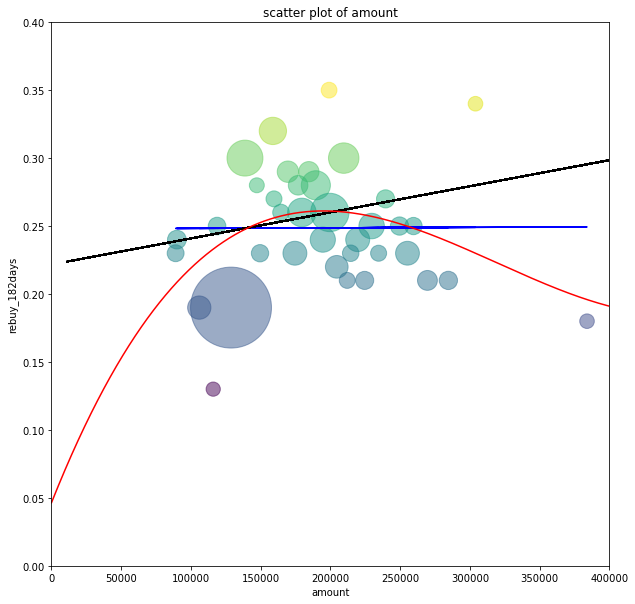

In [715]:
df_amount = df_final_dummies[df_final_dummies['amount'] != 0]

dff_list = [df_aw_ue_pandas_final, df_final_dummies, df_amount]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'amount'
dff_value = 2
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 400000
ylim_min = 0
ylim_max = 0.4

make_graph_amount(feature, dff_number, y_value_number, table)
#avg_table(feature, dff_number, y_value_number).sort_values('count_users',ascending=False).reset_index(drop=True)

### C-2) Discount Amount Ratio


-0.071x0.3366


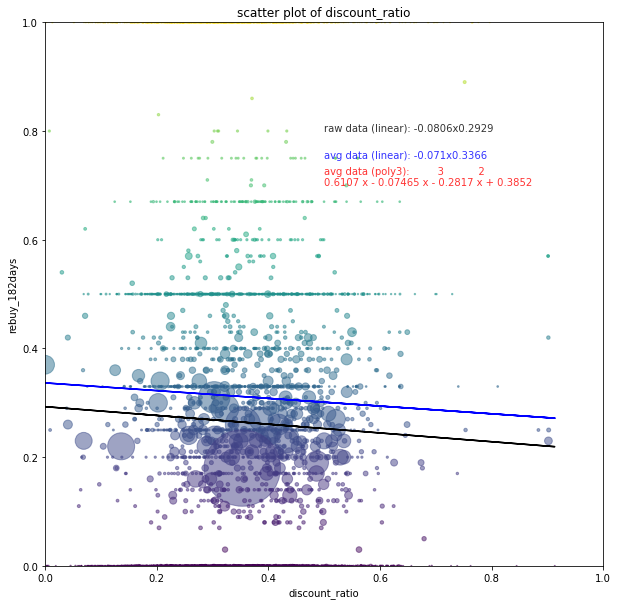

In [716]:
df_amount = df_final_dummies[df_final_dummies['amount'] != 0]

dff_list = [df_aw_ue_pandas_final, df_final_dummies, df_amount]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'discount_ratio'
dff_value = 2
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 1
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### D) Web Lecture View Ratio Within 150 days -- Without 0 and 1


-0.0708x0.4397


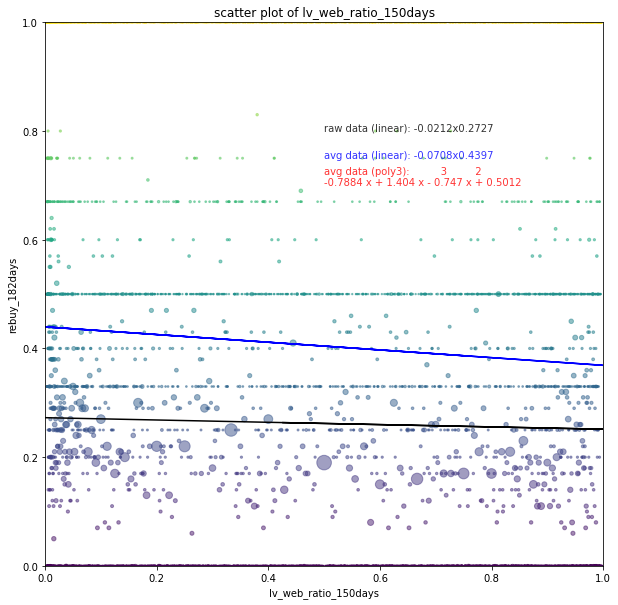

In [639]:
df_web_ratio = df_final_dummies[(df_final_dummies[feature] != 1) & (df_final_dummies[feature] != 0)]

dff_list = [df_aw_ue_pandas_final, df_final_dummies, df_web_ratio]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'lv_web_ratio_150days'
dff_value = 2
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 1
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### E-1) Number of Posts Within 10 Days


0.0063x0.3271


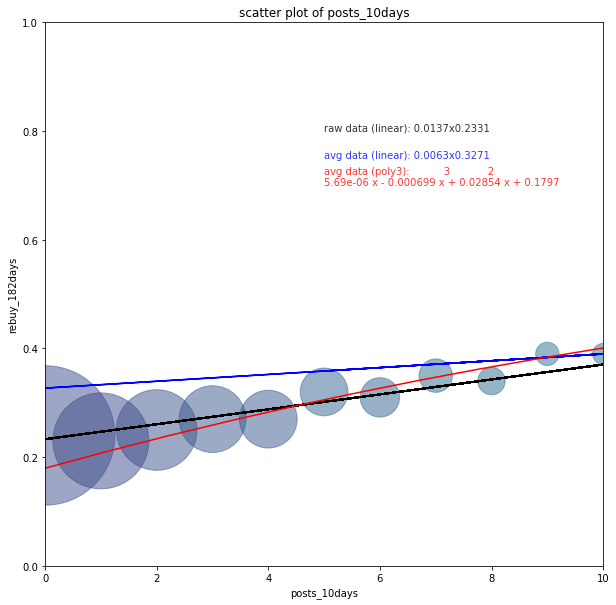

In [640]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'posts_10days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 10
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### E-2) Number of Posts Within 3 Days


0.013x0.2258


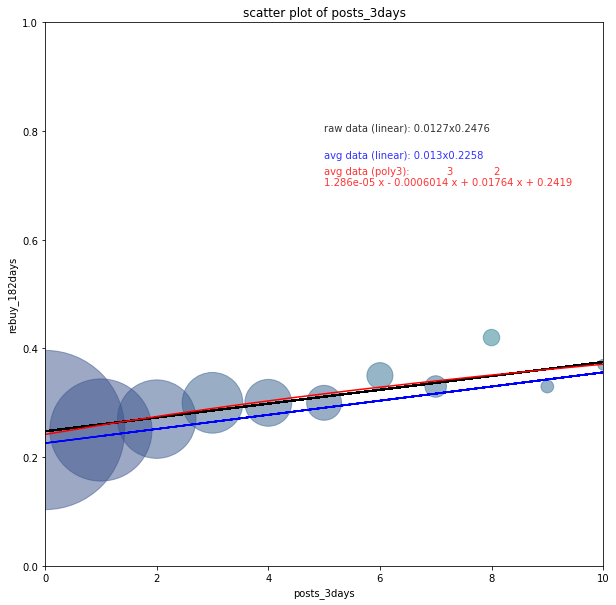

In [641]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'posts_3days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 10
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### E-3) Number of Wishlisted Within 10 Days


0.0013x0.5243


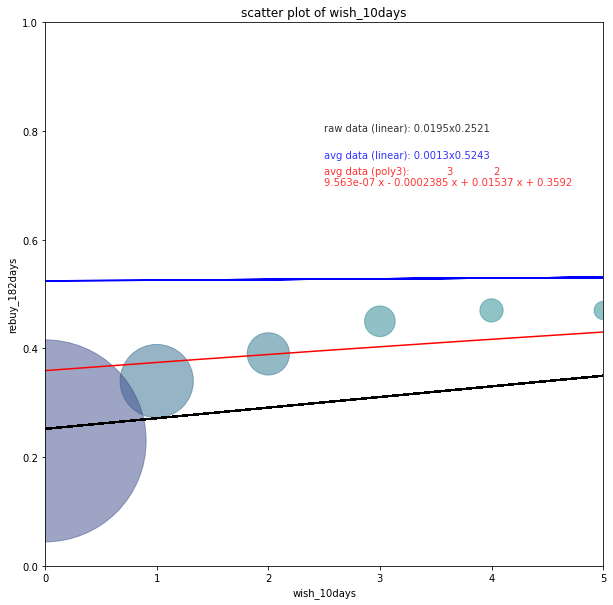

In [642]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'wish_10days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 5
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### E-4) Number of Cheers Before First Buy


0.0028x0.464


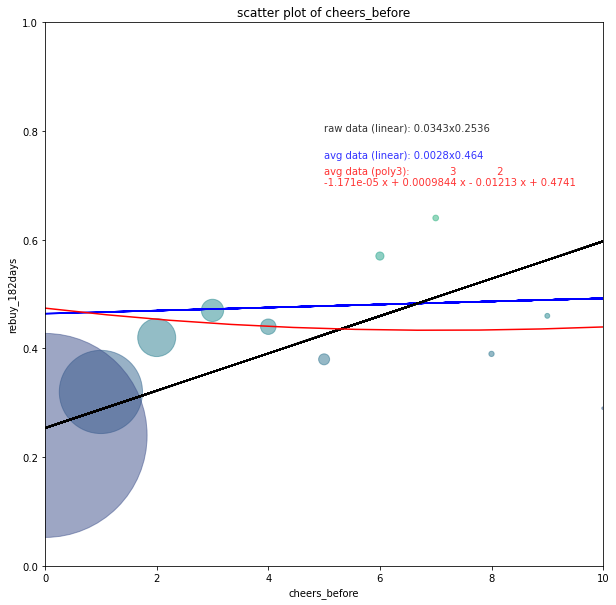

In [643]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'cheers_before'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 10
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### E-5) Number of Non-Mission Posts Within 10 Days


0.0044x0.3116


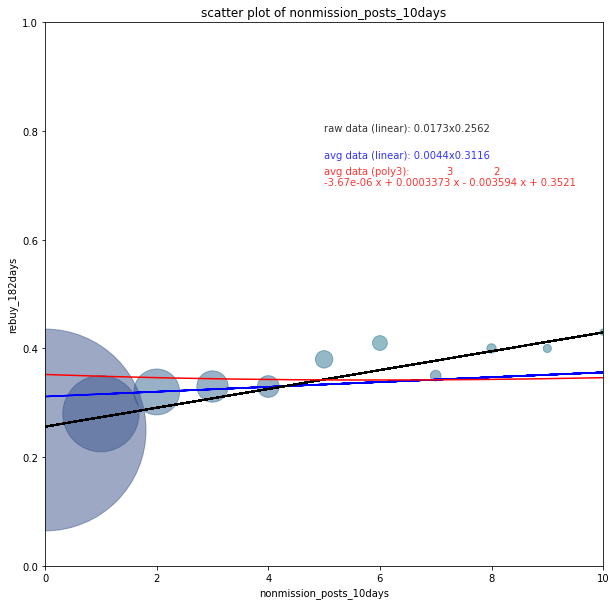

In [644]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'nonmission_posts_10days'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 10
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### F-1) Hero Class?


-0.03x0.28


/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned


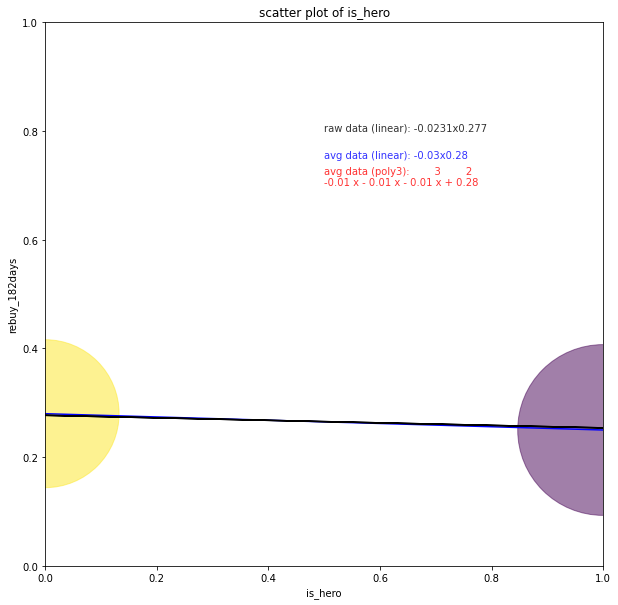

In [645]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'is_hero'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 1
ylim_min = 0
ylim_max = 1

make_graph(feature, dff_number, y_value_number, table)


### F-2) Klass State Earlybird?


0.02x0.26


/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned


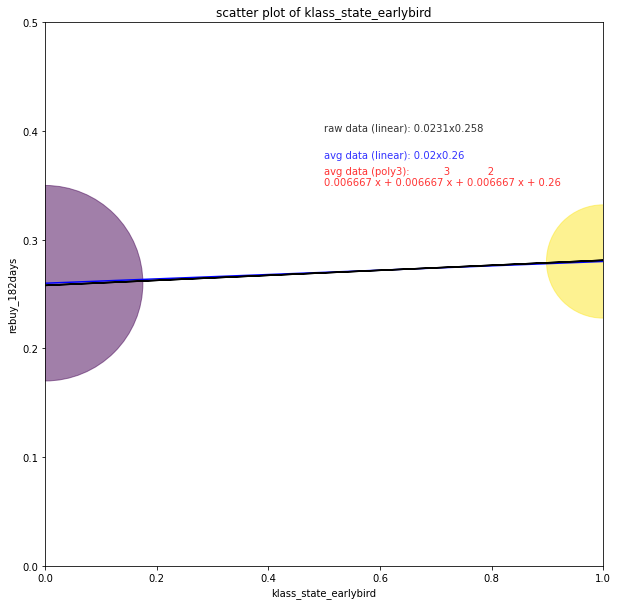

In [646]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'klass_state_earlybird'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 1
ylim_min = 0
ylim_max = 0.5

make_graph(feature, dff_number, y_value_number, table)


In [634]:
#categories and brand

/home/ubuntu/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned



-0.05x0.28


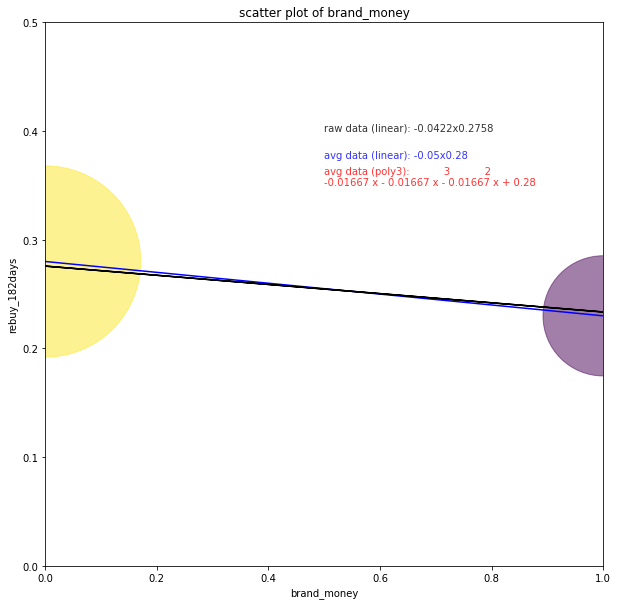

In [635]:
dff_list = [df_aw_ue_pandas_final, df_final_dummies]
y_value_list = ['rebuy_182days', 'sum_revenue_182days']

feature = 'brand_money'
dff_value = 1
y_value = 0
table = 0

dff_number = dff_list[dff_value]
y_value_number = y_value_list[y_value]

xlim_min = 0
xlim_max = 1
ylim_min = 0
ylim_max = 0.5

make_graph(feature, dff_number, y_value_number, table)
